In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import statsmodels
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
print (statsmodels.__version__)

0.8.0rc1


## Визуальный анализ ряда

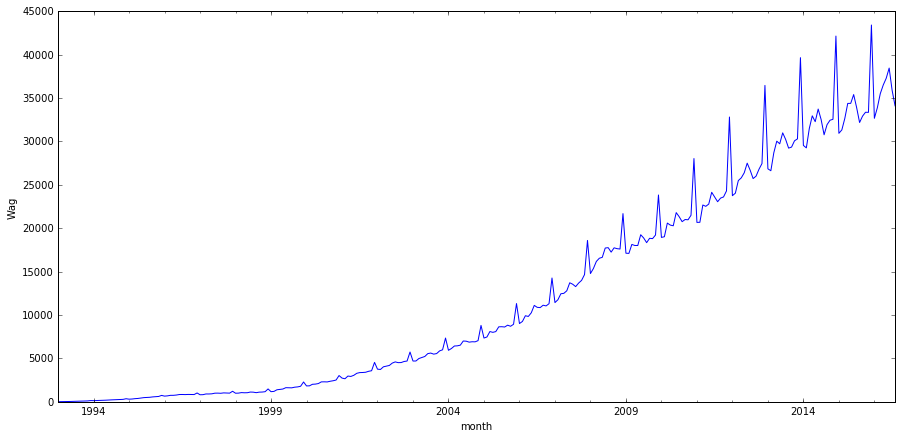

In [3]:
wag = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
wag.WAG_C_M.plot()
plt.ylabel('Wag')
pylab.show()
#wag

## Стабилизация дисперсии. Сделаем преобразование Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


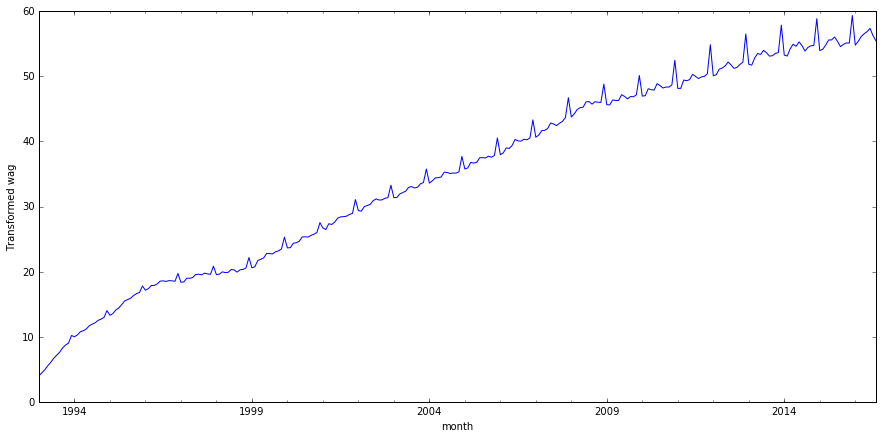

In [4]:
wag['box'], lmbda = stats.boxcox(wag.WAG_C_M)
plt.figure(figsize(15,7))
wag.box.plot()
plt.ylabel(u'Transformed wag')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.box)[1])

# Выбор порядка дифференцирования. Переход к стационарному ряду

### Сезонное дифференцирование

Критерий Дики-Фуллера: p=0.019634


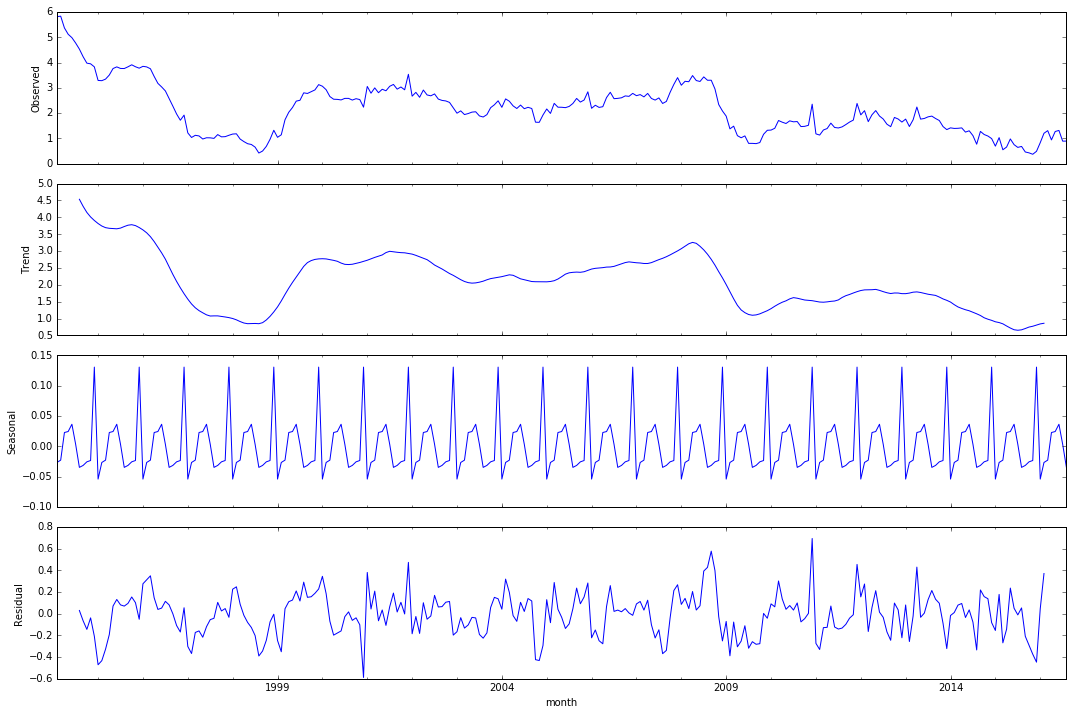

In [5]:
wag['box_diff'] = wag.box - wag.box.shift(12)
plt.figure(figsize(15,10))
wag.dropna(inplace='True')
sm.tsa.seasonal_decompose(wag.box_diff[1:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.box_diff[1:])[1])

### Тренд сохранился. Добавляем обычное дифференцирование

Критерий Дики-Фуллера: p=0.000000


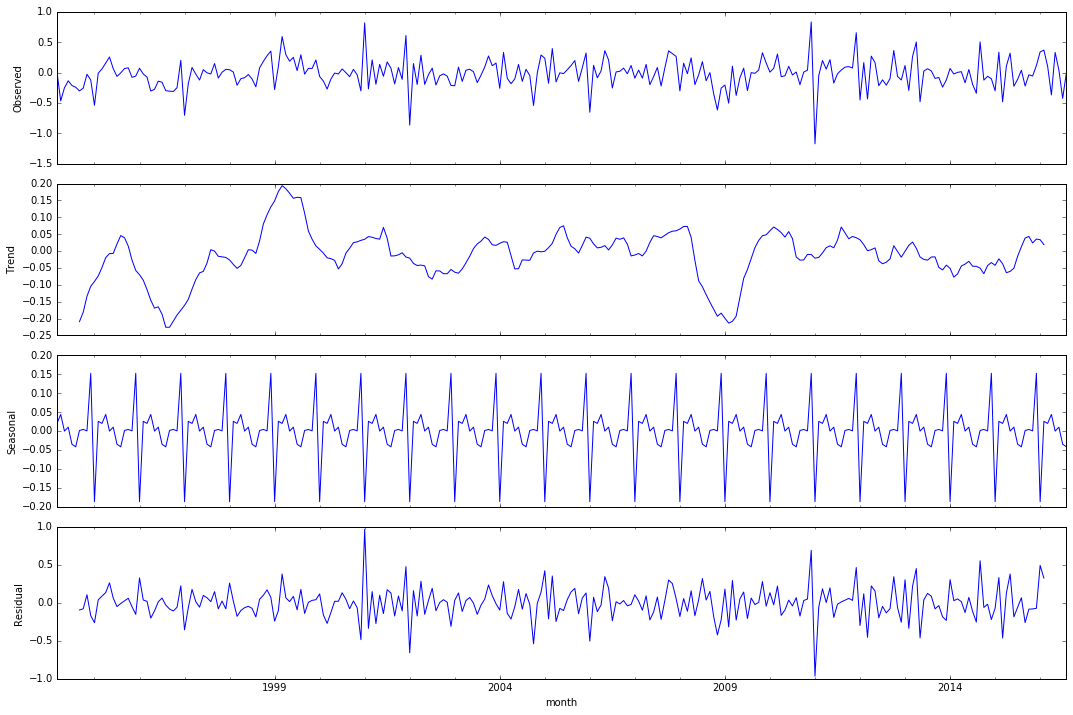

In [6]:
wag['box_diff2'] = wag.box_diff - wag.box_diff.shift(1)
wag.dropna(inplace='True')
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag.box_diff2[1:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.box_diff2[1:])[1])

### Гипотеза нестационарности отвергается, тренда больше нет. 


# Выбор начальных приближений для p,q,P,Q

### Посмотрим на ACF и PACF полученного ряда:

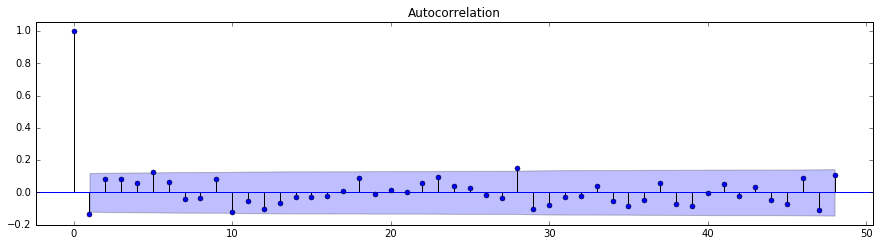

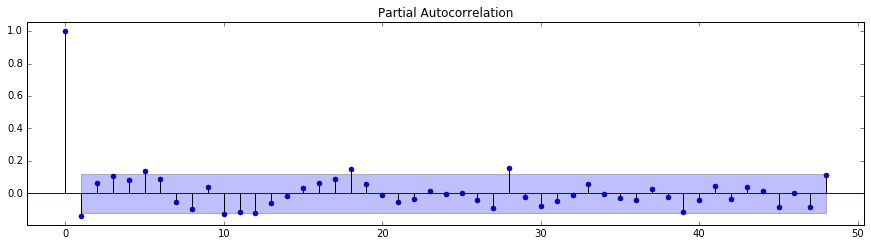

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag.box_diff2[1:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag.box_diff2[1:].values.squeeze(), lags=48, ax=ax)
pylab.show()

### Начальные приближения: Q=1, q=0, P=1, p=0


In [20]:
ps = range(0, 4)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [21]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

## Обучение и сравнение моделей-кандидатов, выбор победителя

In [22]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wag.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
Wall time: 28.2 s


In [23]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
29  (3, 1, 1, 0) -5.285763
28  (3, 1, 0, 1) -5.226752
12  (1, 0, 0, 1) -4.072719
13  (1, 0, 1, 0) -3.974402
30  (3, 1, 1, 1) -3.285784


### Лучшая модель:

In [24]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                box   No. Observations:                  271
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                   8.643
Date:                            Wed, 04 Jan 2017   AIC                             -5.286
Time:                                    14:41:44   BIC                             16.327
Sample:                                02-01-1994   HQIC                             3.392
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4505      0.272      1.653      0.098      -0.083       0.984
ar.L2          0.1573      0.082   

### Её остатки:

Критерий Стьюдента: p=0.545289
Критерий Дики-Фуллера: p=0.000000


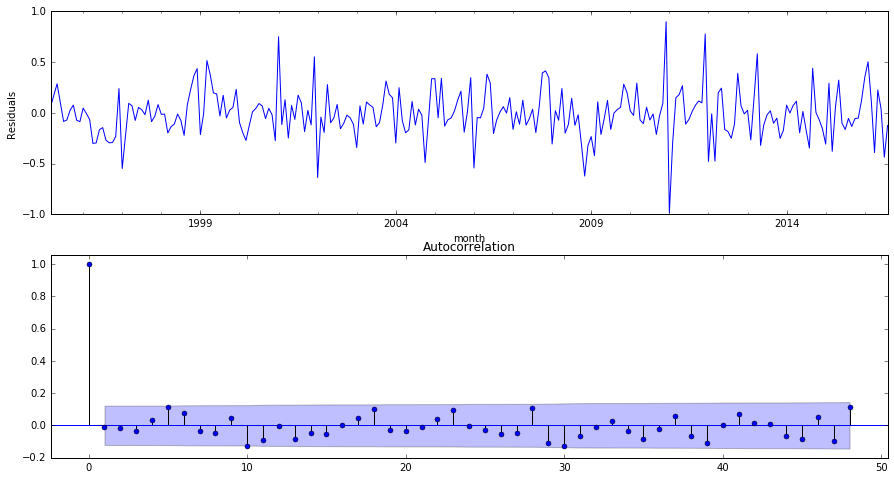

In [25]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

### Остатки несмещены (подтверждается критерием Стьюдента: гипотеза несмещенности не отвергается с достигаемым уровнем значимости 0.55), стационарны (подтверждается критерием Дики-Фуллера: гипотеза нестационарности отвергается, p=0.0), неавтокоррелированы (подтверждается критерием Льюнга-Бокса (p=0.17) и коррелограммой). 

In [30]:
wag

,WAG_C_M,box,box_diff,box_diff2,model
month,,,,,
1994-02-01,144.7,10.272455,5.813697,-0.192106,1.000000
1994-03-01,164.8,10.762540,5.830905,0.017208,144.699998
1994-04-01,171.5,10.916080,5.366650,-0.464255,164.800000
1994-05-01,183.5,11.180371,5.116965,-0.249685,171.500001
1994-06-01,207.5,11.672918,4.982199,-0.134766,183.500000
1994-07-01,221.0,11.931744,4.770434,-0.211766,207.500000
1994-08-01,232.8,12.148599,4.530375,-0.240059,221.000001
1994-09-01,253.2,12.505118,4.229499,-0.300876,232.800001
1994-10-01,265.0,12.701767,3.974933,-0.254567,253.200000


### Проверка результата

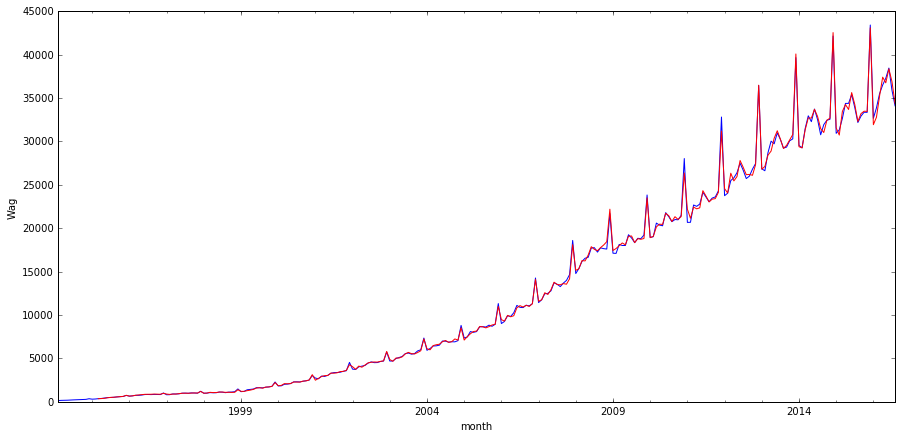

In [27]:
wag['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wag.WAG_C_M.plot()
wag.model[13:].plot(color='r')
plt.ylabel('Wag')
pylab.show()

## Прогнозирование с помощью финальной модели.

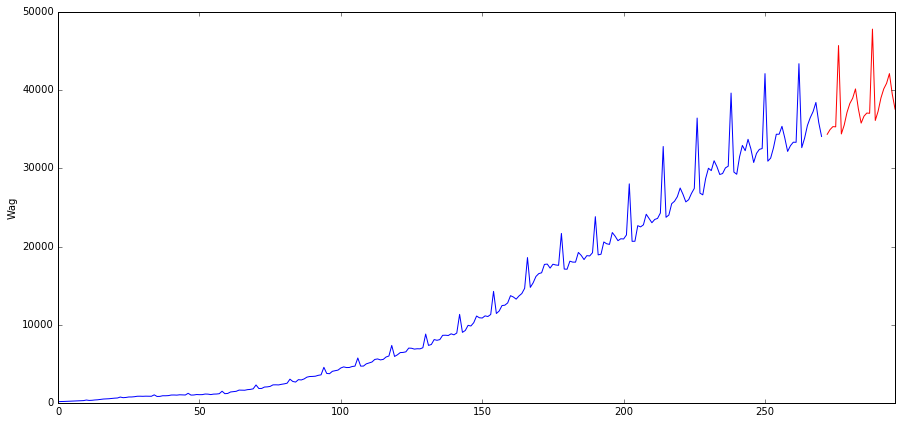

In [59]:
wag2 = wag[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,25)]
future = pd.DataFrame(index=date_list, columns= wag2.columns)
wag2 = pd.concat([wag2, future])
wag2['forecast'] = invboxcox(best_model.predict(start=269, end=308), lmbda)

plt.figure(figsize(15,7))
wag.WAG_C_M.plot()
wag2.forecast.plot(color='r')
plt.ylabel('Wag')
pylab.show()